In [40]:
# !pip install backtesting
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
import pandas as pd
import numpy as np
import yfinance as yf
from backtesting import Backtest
import seaborn as sns
from backtesting.lib import plot_heatmaps

# # https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

class Sma4Cross(Strategy):
    n1 = 70   # SMA 1
    n2 = 160  # SMA 2
    n_enter = 30 # entry sma
    n_exit = 15 # closing sma

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)

    def next(self):
        if not self.position:
            # On upwards trend, if price closes above
            # "entry" MA, go long
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
            # On downwards trend, if price closes below
            # "entry" MA, go short
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()

        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                self.position.close()

In [21]:
KO = pd.DataFrame(yf.Ticker("KO").history(start='2019-01-01', end='2023-09-30', interval='1d'))

In [22]:
%%time
backtest = Backtest(KO, Sma4Cross, commission=.002)
stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 187 ms, sys: 27 ms, total: 214 ms
Wall time: 7.63 s


<Axes: xlabel='n2', ylabel='n1'>

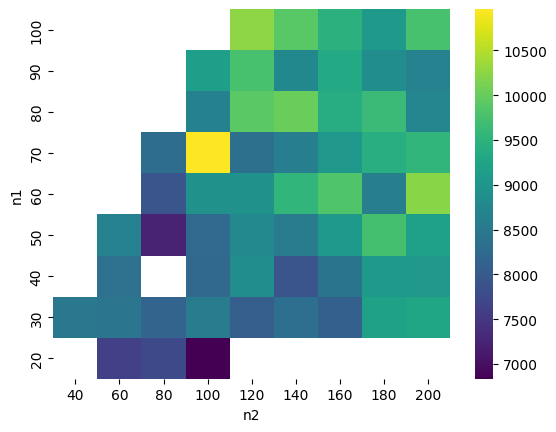

In [27]:
%matplotlib inline
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
sns.heatmap(hm[::-1], cmap='viridis')

In [43]:
plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p5851', ...)

In [44]:
backtest = Backtest(KO, Sma4Cross, commission=.002)
output = backtest.run()
backtest.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p6195', ...)

In [47]:
stats['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
2019-01-02 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-03 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-04 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-07 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-08 00:00:00-05:00,10000.000000,0.000000,NaT
...,...,...,...
2023-09-25 00:00:00-04:00,11594.777583,0.075772,NaT
2023-09-26 00:00:00-04:00,11594.777583,0.075772,NaT
2023-09-27 00:00:00-04:00,11594.777583,0.075772,NaT
2023-09-28 00:00:00-04:00,11594.777583,0.075772,NaT


In [49]:
stats['_equity_curve']


,Equity,DrawdownPct,DrawdownDuration
2019-01-02 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-03 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-04 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-07 00:00:00-05:00,10000.000000,0.000000,NaT
2019-01-08 00:00:00-05:00,10000.000000,0.000000,NaT
...,...,...,...
2023-09-25 00:00:00-04:00,11594.777583,0.075772,NaT
2023-09-26 00:00:00-04:00,11594.777583,0.075772,NaT
2023-09-27 00:00:00-04:00,11594.777583,0.075772,NaT
2023-09-28 00:00:00-04:00,11594.777583,0.075772,NaT


In [48]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,207,202,207,48.176162,47.453069,-149.680180,-0.015009,2019-10-21 00:00:00-04:00,2019-10-28 00:00:00-04:00,7 days 00:00:00
1,203,211,212,48.335429,47.647329,-139.684238,-0.014236,2019-11-01 00:00:00-04:00,2019-11-04 00:00:00-05:00,3 days 01:00:00
2,203,229,244,47.716077,48.074409,72.741241,0.007510,2019-11-27 00:00:00-05:00,2019-12-19 00:00:00-05:00,22 days 00:00:00
3,199,257,288,49.026286,52.219974,635.543955,0.065142,2020-01-09 00:00:00-05:00,2020-02-25 00:00:00-05:00,47 days 00:00:00
4,202,295,296,51.522166,48.875051,-534.717188,-0.051378,2020-03-05 00:00:00-05:00,2020-03-06 00:00:00-05:00,1 days 00:00:00
5,-230,322,334,42.935771,42.178258,174.227973,0.017643,2020-04-14 00:00:00-04:00,2020-04-30 00:00:00-04:00,16 days 00:00:00
6,-247,337,341,40.625095,41.002651,-93.256504,-0.009294,2020-05-05 00:00:00-04:00,2020-05-11 00:00:00-04:00,6 days 00:00:00
7,-244,342,349,40.840036,41.352642,-125.075862,-0.012552,2020-05-12 00:00:00-04:00,2020-05-21 00:00:00-04:00,9 days 00:00:00
8,-235,364,384,41.762361,41.230268,125.041903,0.012741,2020-06-12 00:00:00-04:00,2020-07-13 00:00:00-04:00,31 days 00:00:00
9,-232,413,415,42.783595,43.467003,-158.550580,-0.015974,2020-08-21 00:00:00-04:00,2020-08-25 00:00:00-04:00,4 days 00:00:00


In [53]:
stats

Start                     2019-01-02 00:00...
End                       2023-09-29 00:00...
Duration                   1730 days 23:00:00
Exposure Time [%]                   41.004184
Equity Final [$]                 11594.777583
Equity Peak [$]                  12545.370956
Return [%]                          15.947776
Buy & Hold Return [%]               38.334772
Return (Ann.) [%]                    3.169559
Volatility (Ann.) [%]               11.406305
Sharpe Ratio                         0.277878
Sortino Ratio                        0.403613
Calmar Ratio                         0.232341
Max. Drawdown [%]                  -13.641867
Avg. Drawdown [%]                   -2.990122
Max. Drawdown Duration      501 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                   35
Win Rate [%]                             40.0
Best Trade [%]                       8.990087
Worst Trade [%]                     -5.954057
Avg. Trade [%]                    